# 0. 기본 정보
* 코드 작성자: 여서연
* 코드 작성일: 2024-11-16
* 코드 작성 목적: NLP 및 LDA 토픽 모델링

## 참조 코드 - Topic Modeling using LDA

* https://joyhong.tistory.com/138
* https://github.com/FifthSaint/NewsTextMining201903
* https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
* https://github.com/fastai/course-nlp/blob/master/2-svd-nmf-topic-modeling.ipynb

# 1. 기초 설정

## 사용 라이브러리

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from konlpy.tag import *

In [3]:
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel

In [4]:
import pyLDAvis
#import pyLDAvis.gensim
import pyLDAvis.gensim_models

In [5]:
import warnings
warnings.filterwarnings('ignore')

# 2. 데이터 처리

## A. 크롤링 데이터 불러오기

In [6]:
may = pd.read_csv('../data/[속보]_[05]월_news_data.csv')
oct = pd.read_csv('../data/[속보]_[10]월_news_data.csv')
nov = pd.read_csv('../data/[속보]_[11]월_news_data.csv')

In [7]:
print(may.shape)
print(oct.shape)
print(nov.shape)

(620, 4)
(3036, 4)
(1457, 4)


In [8]:
oct_nov = pd.concat([oct, nov])
oct_nov = oct_nov.reset_index(drop=True)

In [9]:
oct_nov.head()

,Title,Date,Press,Description
0,"[속보] 이스라엘군, 레바논 남부 접경 마을 20여곳 소개령",2024.10.01.,연합뉴스언론사 선정,NaN
1,"[속보] 나토 “한국 등 인태 4개국, 나토 국방장관회의 첫 참석 예정”",2024.10.01.,매일경제언론사 선정,한국을 포함한 인도태평양 4개국(IP4)이 이달 열리는 북대서양조약기구(NATO·나...
2,"[속보] 이시바 시게루, 일본 총리 공식 선출…오늘 새 내각 출범",2024.10.01.,중앙일보언론사 선정,이시바 시게루(67) 일본 집권 자민당 신임 총재가 1일 새 총리로 선출됐다. 이시...
3,"[속보] 헤즈볼라 ""텔아비브 인근 모사드 본부 미사일 공격""",2024.10.01.,강원도민일보언론사 선정,레바논 무장정파 헤즈볼라가 1일(현지시간) 이스라엘 중심도시 텔아비브 인근의 모사드...
4,"[속보] 이스라엘 ""레바논 수도 베이루트 정밀 폭격""",2024.10.01.,TV조선언론사 선정,"이스라엘 ""레바논 수도 베이루트 정밀 폭격"""


In [10]:
oct_nov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4493 entries, 0 to 4492
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        4493 non-null   object
 1   Date         4493 non-null   object
 2   Press        4493 non-null   object
 3   Description  3458 non-null   object
dtypes: object(4)
memory usage: 140.5+ KB


In [11]:
docs = []
for idx in range(len(oct_nov)):
    docs.append(oct_nov['Title'][idx])

In [12]:
docs

['[속보] 이스라엘군, 레바논 남부 접경 마을 20여곳 소개령',
 '[속보] 나토 “한국 등 인태 4개국, 나토 국방장관회의 첫 참석 예정”',
 '[속보] 이시바 시게루, 일본 총리 공식 선출…오늘 새 내각 출범',
 '[속보] 헤즈볼라 "텔아비브 인근 모사드 본부 미사일 공격"',
 '[속보] 이스라엘 "레바논 수도 베이루트 정밀 폭격"',
 '[속보]9월 수출 7.5% 증가…반도체 136억달러 ‘역대 최대’',
 '[속보]광양 23층 아파트서 투신 19세女…극적 구조 성공',
 '[속보] 이스라엘군 "레바논 남부 \'지상 습격\' 시작…헤즈볼라 테러 목표...',
 '[속보]“北으로 돌아갈래”…마을버스 훔쳐 통일대교 건너려던 탈북민...',
 '[속보] 이시바, 일본 102대 총리로 선출…오늘 새 내각 출범',
 '[속보] 이스라엘, 레바논 접경지 봉쇄 거센 포격…지상전 조짐',
 '[속보] 北유엔대사 "합법적 자위권 놓고 과거로 돌아가지 않을 것"',
 '[속보] 윤대통령 "북, 핵무기 사용 기도하는 그날 정권 종말의 날"',
 '[속보] 이시바, 일본 102대 총리로 선출…오늘 새 내각 출범',
 '[속보] 이스라엘군, 레바논 향해 ‘국지적 침공’ 시작···지상전 초읽...',
 '[속보] 이스라엘 "방공망 완벽 준비…이란, 공격시 대가치러야"',
 '[속보]비트코인 3% 대 급락, 6만4000 달러선 깨져…‘이시바 쇼크’ 탓?',
 '[속보] 이스라엘 "레바논 지상작전 되도록 신속히 완료"',
 '[속보] 日이시바 총리 "납북 피해자 문제 해결에 강한 결의"',
 '[속보] "헤즈볼라, 이스라엘 지상군 레바논 진입 부인"<AFP>',
 '[속보] 美백악관 "이란, 이스라엘 직접 군사공격시 심각한 결과 있을것...',
 '[속보] 이스라엘 "지난 1년간 레바논서 수십회 소규모 지상작전"',
 '[속보] 헤즈볼라 "텔아비브 인근 모사드 본부 미사일 공격"',
 '[속보] 롯데 레이예스, 시즌 최종전서 202안타…최다안타 신기록',
 '[속보] 미국 

## B. 구두점 처리

In [13]:
# 제거할 문자와 그 대체값을 딕셔너리로 정의
remove_dict = {
    '.': ' ',   # 마침표 제거
    ',': ' ',   # 쉼표 제거
    "'": ' ',   # 작은따옴표 제거
    '"': ' ',   # 큰따옴표 제거
    '·': ' ',  # 중간 점을 공백으로 대체
    '=': ' ',   # 등호 제거
    '\\n': ' ',  # 개행 문자 제거
    '[': ' ',
    ']': ' ',
    '…': ' ',
    '\\': ' '
}

In [14]:
# 여러 문자 제거를 위한 함수 생성
def CleanText(text, remove_dict):
    for key, value in remove_dict.items():
        text = text.replace(key, value)
    return text

In [15]:
doc_set = []
for doc in docs:
    doc_set.append(CleanText(doc, remove_dict))

In [16]:
doc_set

[' 속보  이스라엘군  레바논 남부 접경 마을 20여곳 소개령',
 ' 속보  나토 “한국 등 인태 4개국  나토 국방장관회의 첫 참석 예정”',
 ' 속보  이시바 시게루  일본 총리 공식 선출 오늘 새 내각 출범',
 ' 속보  헤즈볼라  텔아비브 인근 모사드 본부 미사일 공격 ',
 ' 속보  이스라엘  레바논 수도 베이루트 정밀 폭격 ',
 ' 속보 9월 수출 7 5% 증가 반도체 136억달러 ‘역대 최대’',
 ' 속보 광양 23층 아파트서 투신 19세女 극적 구조 성공',
 ' 속보  이스라엘군  레바논 남부  지상 습격  시작 헤즈볼라 테러 목표   ',
 ' 속보 “北으로 돌아갈래” 마을버스 훔쳐 통일대교 건너려던 탈북민   ',
 ' 속보  이시바  일본 102대 총리로 선출 오늘 새 내각 출범',
 ' 속보  이스라엘  레바논 접경지 봉쇄 거센 포격 지상전 조짐',
 ' 속보  北유엔대사  합법적 자위권 놓고 과거로 돌아가지 않을 것 ',
 ' 속보  윤대통령  북  핵무기 사용 기도하는 그날 정권 종말의 날 ',
 ' 속보  이시바  일본 102대 총리로 선출 오늘 새 내각 출범',
 ' 속보  이스라엘군  레바논 향해 ‘국지적 침공’ 시작   지상전 초읽   ',
 ' 속보  이스라엘  방공망 완벽 준비 이란  공격시 대가치러야 ',
 ' 속보 비트코인 3% 대 급락  6만4000 달러선 깨져 ‘이시바 쇼크’ 탓?',
 ' 속보  이스라엘  레바논 지상작전 되도록 신속히 완료 ',
 ' 속보  日이시바 총리  납북 피해자 문제 해결에 강한 결의 ',
 ' 속보   헤즈볼라  이스라엘 지상군 레바논 진입 부인 <AFP>',
 ' 속보  美백악관  이란  이스라엘 직접 군사공격시 심각한 결과 있을것   ',
 ' 속보  이스라엘  지난 1년간 레바논서 수십회 소규모 지상작전 ',
 ' 속보  헤즈볼라  텔아비브 인근 모사드 본부 미사일 공격 ',
 ' 속보  롯데 레이예스  시즌 최종전서 202안타 최다안타 신기록',
 ' 속보  미국 동남

## C. 불용어 및 자연어 처리

In [17]:
terms = []

In [18]:
stop_word = '속보 그 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 번 나 다른 어떻 여자 개 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 소리 놓'
stopword_list = stop_word.split(' ')
print(stopword_list)

['속보', '그', '이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람', '주', '아니', '등', '같', '우리', '때', '년', '가', '한', '지', '대하', '오', '말', '일', '그렇', '위하', '때문', '그것', '두', '말하', '알', '그러나', '받', '못하', '일', '그런', '또', '문제', '더', '사회', '많', '그리고', '좋', '크', '따르', '중', '나오', '가지', '씨', '시키', '만들', '지금', '생각하', '그러', '속', '하나', '집', '살', '모르', '적', '월', '데', '자신', '안', '어떤', '내', '내', '경우', '명', '생각', '시간', '그녀', '다시', '이런', '앞', '보이', '번', '나', '다른', '어떻', '여자', '개', '전', '들', '사실', '이렇', '점', '싶', '말', '정도', '좀', '원', '잘', '통하', '소리', '놓']


In [19]:
for w in doc_set:
  okt = Okt()
  tokens = okt.nouns(w)
  stop_tokens = [i for i in tokens if not i in stopword_list]
  terms.append(stop_tokens)

In [20]:
print(terms)

[['이스라엘군', '레바논', '남부', '접경', '마을', '곳', '소개', '령'], ['나토', '한국', '인태', '개국', '나토', '국방', '장관', '회의', '첫', '참석', '예정'], ['시바', '시게루', '일본', '총리', '공식', '선출', '오늘', '새', '내각', '출범'], ['헤즈볼라', '텔아비브', '인근', '모사드', '본부', '미사일', '공격'], ['이스라엘', '레바논', '수도', '베이루트', '정밀', '폭격'], ['수출', '증가', '반도체', '역대', '최대'], ['광양', '층', '아파트', '투신', '세', '극적', '구조', '성공'], ['이스라엘군', '레바논', '남부', '지상', '습격', '시작', '헤즈볼라', '테러', '목표'], ['마을', '버스', '통일대교', '탈북민'], ['시바', '일본', '총리', '선출', '오늘', '새', '내각', '출범'], ['이스라엘', '레바논', '접경', '봉쇄', '거', '포격', '지상전', '조짐'], ['유엔', '대사', '합법', '자위권', '과거'], ['윤', '대통령', '북', '핵무기', '사용', '기도', '그날', '정권', '종말', '날'], ['시바', '일본', '총리', '선출', '오늘', '새', '내각', '출범'], ['이스라엘군', '레바논', '향', '국', '지적', '침공', '시작', '지상전', '초'], ['이스라엘', '방공', '망', '완벽', '준비', '이란', '공격', '시', '대가'], ['비트코인', '급락', '달러', '선', '시바', '쇼크', '탓'], ['이스라엘', '레바논', '지상', '작전', '완료'], ['시바', '총리', '납북', '피해자', '해결', '결의'], ['헤즈볼라', '이스라엘', '지상군', '레바논', '진입', '부인'], ['백악관', '이란', '이스라엘', '직접', '군사

## D. 사전과 문서-단어행렬 생성

In [21]:
#training vocabulary
dictionary = corpora.Dictionary(terms)

In [22]:
## 문서-단어 행렬(document-term matrix) 생성
corpus = [dictionary.doc2bow(term) for term in terms]

In [23]:
print(dictionary)

Dictionary<5381 unique tokens: ['곳', '남부', '레바논', '령', '마을']...>


In [24]:
corpus[0][:5]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]

In [25]:
print(corpus)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)], [(8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)], [(18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)], [(28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1)], [(2, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)], [(40, 1), (41, 1), (42, 1), (43, 1), (44, 1)], [(45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1)], [(1, 1), (2, 1), (6, 1), (34, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1)], [(4, 1), (58, 1), (59, 1), (60, 1)], [(19, 1), (20, 1), (21, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)], [(2, 1), (7, 1), (37, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1)], [(66, 1), (67, 1), (68, 1), (69, 1), (70, 1)], [(71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1)], [(19, 1), (20, 1), (21, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)], [(2, 1), (6, 1), (55, 1), (64, 1),

## E. TF-IDF 계산

In [26]:
#tfidf document-term matrix
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
corpus_tfidf[0][:5]

[(0, 0.291834651632258),
 (1, 0.3103015138254271),
 (2, 0.24854300372368426),
 (3, 0.43381853402891285),
 (4, 0.32442915905367825)]

## F. LDA 분석

In [27]:
model = gensim.models.LdaModel(
    corpus,
    num_topics=9, # 출력 토픽 수
    id2word=dictionary,
    random_state=42
)

In [28]:
# 각 토픽과 그 토픽에 속하는 단어를 중요도(확률)와 함께 출력
# num_topics: 출력할 토픽의 개수를 지정
# num_words: 각 토픽에서 상위 N개의 주요 단어 출력
model.show_topics(4, 10)

[(2,
  '0.024*"징역" + 0.022*"심" + 0.019*"트럼프" + 0.016*"개월" + 0.015*"환율" + 0.014*"정부" + 0.012*"수출" + 0.010*"공개" + 0.009*"내년" + 0.009*"의대"'),
 (1,
  '0.018*"트럼프" + 0.018*"이재명" + 0.017*"대선" + 0.015*"한동훈" + 0.015*"총" + 0.014*"부회장" + 0.012*"대통령" + 0.010*"윤" + 0.010*"발탁" + 0.010*"대통령실"'),
 (8,
  '0.027*"돌파" + 0.023*"북한" + 0.017*"비트코인" + 0.015*"달러" + 0.013*"대통령" + 0.012*"선" + 0.011*"처음" + 0.011*"확정" + 0.011*"국정원" + 0.011*"파병"'),
 (0,
  '0.025*"이재명" + 0.019*"선고" + 0.019*"균" + 0.019*"명태" + 0.019*"심" + 0.014*"대통령" + 0.014*"장교" + 0.013*"선" + 0.011*"김영선" + 0.011*"발언"')]

In [29]:
NUM_TOPICS = 9
TOP_N = 20

word_dict = {}
for i in range(NUM_TOPICS):
  words = model.show_topic(i, topn=TOP_N)
  word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
  word_df = pd.DataFrame(word_dict)

In [30]:
word_df

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08,Topic #09
0,이재명,트럼프,징역,법원,전자,트럼프,대통령,통과,돌파
1,선고,이재명,심,힘,삼성,위반,코스피,국회,북한
2,균,대선,트럼프,통과,의정,당선,한미,연세대,비트코인
3,명태,한동훈,개월,고려아연,돌파,선거법,본회의,주가,달러
4,심,총,환율,의원,비트코인,공직선거법,장관,조율,대통령
5,대통령,부회장,정부,코스닥,여야,의협,윤,증시,선
6,장교,대통령,수출,대통령실,체,북한,대통령실,공개,처음
7,선,윤,공개,자,붕괴,현대차,위원장,경제,확정
8,김영선,발탁,내년,국민,협의,한국,추진,한국,국정원
9,발언,대통령실,의대,구속영장,영업,집유,정상,관찰,파병


In [31]:
model.print_topics(num_words=5)

[(0, '0.025*"이재명" + 0.019*"선고" + 0.019*"균" + 0.019*"명태" + 0.019*"심"'),
 (1, '0.018*"트럼프" + 0.018*"이재명" + 0.017*"대선" + 0.015*"한동훈" + 0.015*"총"'),
 (2, '0.024*"징역" + 0.022*"심" + 0.019*"트럼프" + 0.016*"개월" + 0.015*"환율"'),
 (3, '0.033*"법원" + 0.017*"힘" + 0.016*"통과" + 0.015*"고려아연" + 0.014*"의원"'),
 (4, '0.022*"전자" + 0.021*"삼성" + 0.019*"의정" + 0.017*"돌파" + 0.017*"비트코인"'),
 (5, '0.044*"트럼프" + 0.019*"위반" + 0.018*"당선" + 0.018*"선거법" + 0.013*"공직선거법"'),
 (6, '0.026*"대통령" + 0.022*"코스피" + 0.019*"한미" + 0.019*"본회의" + 0.014*"장관"'),
 (7, '0.015*"통과" + 0.010*"국회" + 0.010*"연세대" + 0.009*"주가" + 0.008*"조율"'),
 (8, '0.027*"돌파" + 0.023*"북한" + 0.017*"비트코인" + 0.015*"달러" + 0.013*"대통령"')]

In [32]:
# 문서의 토픽 분포를 반환 = (토픽 번호, 확률)
for i in range(9):
    print(model.get_document_topics(corpus)[i])

[(0, 0.012379904), (1, 0.012396484), (2, 0.012381275), (3, 0.012388842), (4, 0.012397664), (5, 0.69273174), (6, 0.22056131), (7, 0.01238227), (8, 0.01238053)]
[(6, 0.27473447), (8, 0.6604308)]
[(0, 0.01010395), (1, 0.010104197), (2, 0.91914636), (3, 0.010105215), (4, 0.01010518), (5, 0.01010816), (6, 0.010114134), (7, 0.010104339), (8, 0.010108454)]
[(0, 0.88875663), (1, 0.013923394), (2, 0.0138998), (3, 0.0139029855), (4, 0.013901411), (5, 0.013921004), (6, 0.013899667), (7, 0.013898039), (8, 0.013897058)]
[(0, 0.015886705), (1, 0.01590217), (2, 0.11617651), (3, 0.015899196), (4, 0.015886525), (5, 0.015894668), (6, 0.77256495), (7, 0.01589743), (8, 0.015891815)]
[(0, 0.01852013), (1, 0.018519484), (2, 0.41688898), (3, 0.018520154), (4, 0.45345846), (5, 0.01852659), (6, 0.018521141), (7, 0.018524203), (8, 0.018520817)]
[(0, 0.90101606), (1, 0.012367693), (2, 0.012377928), (3, 0.012378024), (4, 0.012370268), (5, 0.01238372), (6, 0.012367782), (7, 0.012368508), (8, 0.01236995)]
[(0, 0.01

## G. pyLDAvis를 이용한 시각화

In [33]:
pyLDAvis.enable_notebook()

#data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
data = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)

data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.055432  0.089078       1        1  12.637468
6     -0.135327 -0.036134       2        1  12.571483
2      0.142675  0.185132       3        1  12.296085
8      0.081127 -0.098213       4        1  11.493996
4      0.138711 -0.195459       5        1  11.223136
0     -0.089138 -0.015452       6        1  10.424636
1     -0.054653  0.015787       7        1   9.981902
3     -0.137371  0.011738       8        1   9.800458
7     -0.001456  0.043522       9        1   9.570836, topic_info=      Term        Freq       Total Category  logprob  loglift
979    트럼프  340.000000  340.000000  Default  30.0000  30.0000
391     법원  131.000000  131.000000  Default  29.0000  29.0000
1150    돌파  173.000000  173.000000  Default  28.0000  28.0000
353      심  165.000000  165.000000  Default  27.0000  27.0000
727     통과   98.000000   98.000000  Default  26.0000  26.0000
...    ...         ...         ...      ...      ...      ...
321      제   16.031725   42.395322   Topic9  -5.2530   1.3740
444   대통령실   20.960865  207.275404   Topic9  -4.9849   0.0551
922     경기   14.623457   32.809358   Topic9  -5.3449   1.5384
201     한미   16.273539   98.912131   Topic9  -5.2380   0.5418
520      총   15.551607   63.906506   Topic9  -5.2834   0.9332

[529 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2633      9  0.822618   가도
2683      8  0.835380   가열
387       8  0.966193  가처분
1319      5  0.858754   가치
1319      7  0.095417   가치
...     ...       ...  ...
1589      4  0.013725    힘
1589      5  0.027450    힘
1589      6  0.082349    힘
1589      8  0.713694    힘
1589      9  0.068624    힘

[1220 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 3, 9, 5, 1, 2, 4, 8])

## H. LDA 토픽개수 지정

In [34]:
print('\nPerplexity: ', model.log_perplexity(corpus))
coherence_model_lda = CoherenceModel(model=model, texts=terms, dictionary=dictionary, topn=10)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.85372509173421

Coherence Score:  0.41267369860383396


In [35]:
perplexity_values = []
for i in range(2,10):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary, random_state=42)
    perplexity_values.append(ldamodel.log_perplexity(corpus))

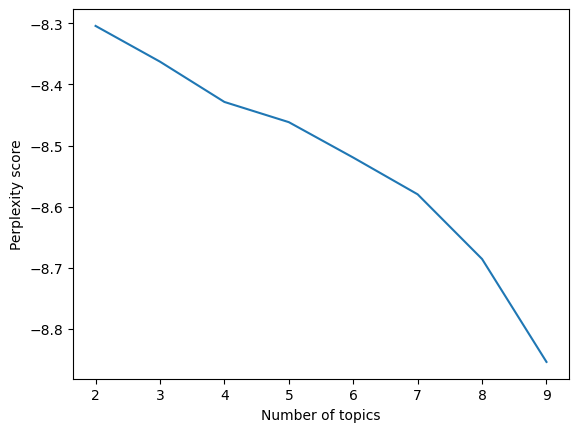

In [36]:
x = range(2,10)
plt.plot(x, perplexity_values)
plt.xlabel("Number of topics")
plt.ylabel("Perplexity score")
plt.show()

In [37]:
coherence_values = []
for i in range(2,10):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary, random_state=42)
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=terms, dictionary=dictionary, topn=10)
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

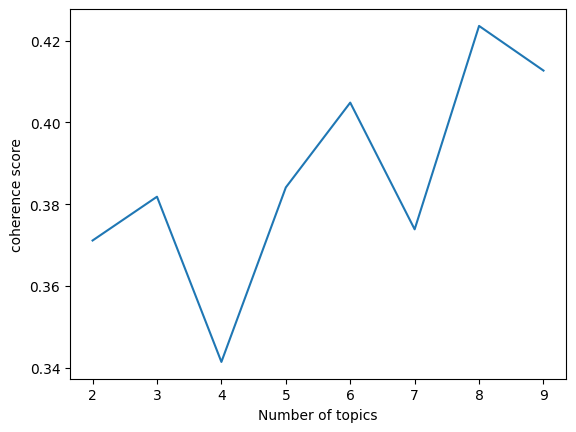

In [38]:
x = range(2,10)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("coherence score")
plt.show()

최종적으로 Perplexity와 Coherence Score를 동시에 고려하여 최적의 주제 수를 선택
</br>
일반적으로 Coherence Score가 더 중요한 평가 지표로 간주됩니다.

## I. 최종 LDA 분석

In [39]:
NUM_TOPICS = 8

In [40]:
model = gensim.models.LdaModel(
    corpus,
    num_topics=NUM_TOPICS, # 출력 토픽 수
    id2word=dictionary,
    random_state=42
)

In [41]:
# 각 토픽과 그 토픽에 속하는 단어를 중요도(확률)와 함께 출력
# num_topics: 출력할 토픽의 개수를 지정
# num_words: 각 토픽에서 상위 N개의 주요 단어 출력
model.show_topics(4, 10)

[(3,
  '0.027*"법원" + 0.019*"트럼프" + 0.014*"지명" + 0.011*"대통령실" + 0.010*"고려아연" + 0.010*"북한" + 0.010*"통과" + 0.010*"장교" + 0.009*"구속영장" + 0.009*"의원"'),
 (5,
  '0.042*"트럼프" + 0.018*"선거법" + 0.015*"환율" + 0.015*"당선" + 0.013*"북한" + 0.012*"의협" + 0.011*"한국" + 0.010*"위반" + 0.009*"이란" + 0.008*"의미"'),
 (6,
  '0.024*"코스피" + 0.019*"대통령" + 0.016*"이재명" + 0.014*"윤" + 0.012*"붕괴" + 0.012*"한미" + 0.011*"국회" + 0.011*"선" + 0.011*"위반" + 0.011*"정상"'),
 (4,
  '0.037*"돌파" + 0.030*"비트코인" + 0.016*"최고" + 0.016*"사상" + 0.015*"달러" + 0.013*"영업" + 0.013*"전자" + 0.012*"트럼프" + 0.011*"삼성" + 0.009*"전투"')]

In [42]:
TOP_N = 20

word_dict = {}
for i in range(NUM_TOPICS):
  words = model.show_topic(i, topn=TOP_N)
  word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
  word_df = pd.DataFrame(word_dict)

In [43]:
word_df

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08
0,이재명,통과,개월,법원,돌파,트럼프,코스피,붕괴
1,심,본회의,수출,트럼프,비트코인,선거법,대통령,항소
2,선고,대통령실,공개,지명,최고,환율,이재명,본회의
3,대통령,한동훈,증가,대통령실,사상,당선,윤,발탁
4,의정,집유,현대차,고려아연,달러,북한,붕괴,주가
5,협의,직,신상,북한,영업,의협,한미,개월
6,여야,최윤,정부,통과,전자,한국,국회,추락
7,징역,성장,뉴욕증시,장교,트럼프,위반,선,로
8,체,이재명,회,구속영장,삼성,이란,위반,연세대
9,윤,쿠르스크,상승,의원,전투,의미,정상,발생


In [44]:
model.print_topics(num_words=5)

[(0, '0.029*"이재명" + 0.024*"심" + 0.020*"선고" + 0.020*"대통령" + 0.016*"의정"'),
 (1, '0.016*"통과" + 0.016*"본회의" + 0.014*"대통령실" + 0.013*"한동훈" + 0.011*"집유"'),
 (2, '0.020*"개월" + 0.015*"수출" + 0.013*"공개" + 0.012*"증가" + 0.010*"현대차"'),
 (3, '0.027*"법원" + 0.019*"트럼프" + 0.014*"지명" + 0.011*"대통령실" + 0.010*"고려아연"'),
 (4, '0.037*"돌파" + 0.030*"비트코인" + 0.016*"최고" + 0.016*"사상" + 0.015*"달러"'),
 (5, '0.042*"트럼프" + 0.018*"선거법" + 0.015*"환율" + 0.015*"당선" + 0.013*"북한"'),
 (6, '0.024*"코스피" + 0.019*"대통령" + 0.016*"이재명" + 0.014*"윤" + 0.012*"붕괴"'),
 (7, '0.011*"붕괴" + 0.011*"항소" + 0.010*"본회의" + 0.009*"발탁" + 0.009*"주가"')]

In [45]:
# 문서의 토픽 분포를 반환 = (토픽 번호, 확률)
for i in range(9):
    print(model.get_document_topics(corpus)[i])

[(0, 0.013939461), (1, 0.013937244), (2, 0.0139300665), (3, 0.013937244), (4, 0.013940588), (5, 0.14259303), (6, 0.7737836), (7, 0.01393873)]
[(0, 0.010436307), (1, 0.01042576), (2, 0.010420928), (3, 0.010442387), (4, 0.010427619), (5, 0.40799907), (6, 0.5294244), (7, 0.0104235)]
[(0, 0.011368011), (1, 0.011369411), (2, 0.92041695), (3, 0.011367209), (4, 0.011367851), (5, 0.011374354), (6, 0.011368018), (7, 0.011368187)]
[(0, 0.015669156), (1, 0.23896256), (2, 0.015658198), (3, 0.015666021), (4, 0.66705775), (5, 0.015672883), (6, 0.015657976), (7, 0.015655475)]
[(0, 0.01787723), (1, 0.017905511), (2, 0.01788276), (3, 0.017892864), (4, 0.017881718), (5, 0.24386089), (6, 0.5168742), (7, 0.14982483)]
[(0, 0.02083473), (1, 0.02083445), (2, 0.85410756), (3, 0.020836053), (4, 0.02086458), (5, 0.020845208), (6, 0.020835763), (7, 0.020841649)]
[(0, 0.47439244), (1, 0.013947085), (2, 0.30934945), (3, 0.14651689), (4, 0.01394701), (5, 0.013951703), (6, 0.013945017), (7, 0.013950358)]
[(0, 0.0125

## G. 최종 pyLDAvis 시각화

In [46]:
pyLDAvis.enable_notebook()

#data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
data = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)

data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.054580  0.083914       1        1  14.309582
0     -0.170660 -0.077474       2        1  13.509775
6     -0.151570 -0.018084       3        1  13.438866
3     -0.003873  0.194592       4        1  12.336736
4      0.122057  0.027245       5        1  12.158486
2      0.172989 -0.146136       6        1  11.933754
1     -0.038430 -0.058505       7        1  11.432135
7      0.014906 -0.005552       8        1  10.880666, topic_info=      Term        Freq       Total Category  logprob  loglift
979    트럼프  327.000000  327.000000  Default  30.0000  30.0000
1150    돌파  179.000000  179.000000  Default  29.0000  29.0000
488    이재명  237.000000  237.000000  Default  28.0000  28.0000
391     법원  118.000000  118.000000  Default  27.0000  27.0000
95    비트코인  140.000000  140.000000  Default  26.0000  26.0000
...    ...         ...         ...      ...      ...      ...
75       북   18.410549   48.775232   Topic8  -5.2429   1.2439
506     하락   20.676383   78.383914   Topic8  -5.1268   0.8856
1706    당선   21.628888  101.786200   Topic8  -5.0818   0.6693
511     공개   19.026148   73.276407   Topic8  -5.2100   0.8698
201     한미   17.484692   86.873665   Topic8  -5.2945   0.6151

[489 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2824      1  0.906081   가능
2824      4  0.086293   가능
831       1  0.664090  가능성
831       3  0.023718  가능성
831       5  0.023718  가능성
...     ...       ...  ...
1589      2  0.236820    힘
1589      3  0.103609    힘
1589      4  0.503242    힘
1589      5  0.044404    힘
1589      8  0.088807    힘

[1097 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 7, 4, 5, 3, 2, 8])